In [108]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.sparse as sp

## Parameters

#### constants definition

In [109]:
horizon = 480                   #5 days, 15-min intervals
dt = 0.25                       # hours per time slot (15 min ⇒ 0.25 h)
slots_per_day = 96              # total 15-min slots per day
n_days = 5                      # number of days
opening_hour = 9                # Opening hour of the factory: 9:00 → slot 36
closing_hour = 18               # Closing hour of the factory: 18:00 → slot 72 (exclusive upper bound)

#DATA LOADING-----------------------------------------------------------------
#demand
factor_profile_demand = 50000/1000000 # factor for profil demand scaling
#pv
PV_area = 200 # m²
PV_efficiency = 0.2             # 20% efficiency of the energy conversion
#price
base_price = 22.16/100          #in CHF/kWh with TVA
peak_price = 32.52/100          #in CHF/kWh with TVA

#MODELING--------------------------------------------------------------------
#ev
n_EVS = 15                      # number of EVs
power_EV_rated = 4.0            # kW, max charger power
energy_EV_req = 6.0             # kWh, daily depleted energy of 6 kWh per EV
battery_capacity=40.0           # kWh, battery capacity of each EV
soc_initial=20.0                # kWh, initial state of charge of each EV (50% of battery capacity)
soc_target=26.0                 # kWh, target state of charge of each EV (65% of battery capacity) 20 + energy_EV_req
eff_charge=0.95
eff_discharge=0.95

#AMM
n_AMM = 5                       # number of AM machines
power_AMM = 2.76                # Power consumption of each printer in kW
duration_AMM = 16               # Full cycle of a printer corresponds to 4 hours of operation (or 16 slots of 15 minutes)

#heating
COP_h = 2.5                     # Heating COP
COP_c = 2.5                     # Cooling COP
inertia = 0.98                  # Inertia factor ϵ
A_th = 2.0                      # Thermal conductivity [kW/°C]
T_desired = 19.0                # Setpoint temperature [°C]
dead_band = 2.0                 # ± dead-band [°C]
T_lower = T_desired - dead_band # Lower comfort limit (17°C)
T_upper = T_desired + dead_band # Upper comfort limit (21°C)
T_0 = T_lower                   # Initial indoor temperature (set here at the lower bound, can be modified)

power_threshold = 40           # Power consumption (importation) must stay below this at any time [kW]


#### models definition

In [110]:
model1 = gp.Model("ADR") # Scenario 1: Dynamic pricing  + PV generation
model2 = gp.Model("ADR") # Scenario 2: Dynamic pricing  + No-PV generation
model3 = gp.Model("ADR") # Scenario 3: BasePeak pricing + PV generation
model4 = gp.Model("ADR") # Scenario 4: BasePeak pricing + No-PV generation

## Data Loading

### Electricity demand

In [111]:
profile_demand = pd.read_csv('Demand_Data_15min.csv', sep=',', decimal='.')
real_demand= profile_demand['Demand'] * factor_profile_demand
critical_demand= np.array(real_demand)

#plot the Demand Column
# plt.plot(real_demand)
# plt.title('Demand Profile')
# plt.xlabel('Time Interval')
# plt.ylabel('Demand [kWh]')
# plt.show()


### Electricity price loading

In [112]:
dynamic_prices = pd.read_csv('VarioPlus_2019-04-07_to_2019-04-11_15min.csv',parse_dates=['time'],index_col='time')# we should change dynamic_prices for dyn_prices
dynamic_prices['price'] = dynamic_prices['price'] / 100 #conversion from cts/kWh to CHF/kWh

#create an array called Base_Peak_price where price from 7 to 21 is Peak Price and base otherwise 
start = dynamic_prices.index[0]
rng = pd.date_range(start, periods=horizon, freq='15T')
prices = [ peak_price if 7 <= ts.hour < 21 else base_price for ts in rng ]

Base_Peak_price_df = (pd.DataFrame({'price': prices}, index=rng) ) #dataframe with price for printing correctly

# plt.figure(figsize=(12, 4))
# plt.plot(dynamic_prices.index, dynamic_prices['price'],label='Spot Price')
# plt.plot(Base_Peak_price_df.index, Base_Peak_price_df['price'], label='Base/Peak Price', color='red')

# plt.title('Prices(15 min) of GroupE VarioPlus and Bease/Peak option — 7 to 11 Apr 2019')
# plt.xlabel('Time Interval')
# plt.ylabel('Price [CHF/kWh]')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

dynamic_prices = np.array(dynamic_prices['price']) # convert to an array
Base_Peak_prices = np.array(Base_Peak_price_df['price'])

/var/folders/0w/44rywk3j1dl_gqy839v3wqyh0000gn/T/ipykernel_23595/1345007373.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  rng = pd.date_range(start, periods=horizon, freq='15T')


### Temperature loading

In [113]:
# import and display Temperature_Data_Zurich_15min.csv
temperature_data = pd.read_csv('Temperature_Data_Zurich_15min.csv', parse_dates=['time'])

# Plot the temperature (°C) at 15-minute intervals
# plt.figure(figsize=(12, 4))
# plt.plot(temperature_data.index, temperature_data['temperature'], color='blue')
# plt.title('Temperature in Zurich (7–11 April 2019, 15-min resolution)')
# plt.xlabel('Date and Time')
# plt.ylabel('Temperature [°C]')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

### Solar irradiance

In [114]:
solar_energy = pd.read_csv('Solar_Energy_Zurich_15min.csv') #kWh/m²
PV_energy = solar_energy['Energy [kWh/m²]'] * PV_area * PV_efficiency # kWh
PV_power = PV_energy / dt # kW, *4 = dt^(-1) pour l avoir en kW. 
PV_power = np.array(PV_power)

#Plot the solar energy (kWh) at 15-minute intervals
# plt.figure(figsize=(12, 4))
# plt.plot(solar_energy.index, PV_power, color='green')
# plt.title('PV Energy generated in Zurich (7–11 April 2019, 15-min resolution)')
# plt.xlabel('Date and Time')
# plt.ylabel('Energy [kW]')
# plt.grid(True)
# plt.tight_layout()
# plt.show()  

## Modelling 

### EVs:

In [115]:
def ev_modeling(price, model, n_EVS, n_days, slots_per_day, dt, opening_hour, closing_hour, energy_EV_req, power_EV_rated, battery_capacity, soc_initial, soc_target,eff_charge, eff_discharge):
    EVS = range(n_EVS) # index set for EVs
    days = range(n_days) # index set for days
    slots = range(slots_per_day) # index set for time slots

    start_idx = opening_hour * 4    # 9:00 → slot 36
    end_idx = closing_hour * 4      # 18:00 → slot 72 (exclusive upper bound)

    # continuous variable p_ev[e,d,t] ∈ [0, power_EV_rated] = charging power of EV e in slot t (kW)
    p_ev = model.addVars(EVS, days, slots, lb=0, ub=power_EV_rated,
                                vtype=GRB.CONTINUOUS, name="p_ev_charge")

    p_ev_discharge = model.addVars(EVS, days, slots, lb=0, ub=power_EV_rated,
                                vtype=GRB.CONTINUOUS, name="p_ev_discharge")

    soc = model.addVars(EVS, days, slots, lb=0, ub=battery_capacity,
                        vtype=GRB.CONTINUOUS, name="soc")
    
        # Constraints
    for e in EVS:
        for d in days:
            for t in slots:
                #1) Zero charging/discharging outside allowed time window
                if t < start_idx or t >= end_idx:
                    model.addConstr(p_ev[e, d, t] == 0, name=f"no_charge_e{e}_d{d}_t{t}")
                    model.addConstr(p_ev_discharge[e, d, t] == 0, name=f"no_discharge_e{e}_d{d}_t{t}")

            for t in slots:
                if t == 0:
                    # 2)Initial state of charge at start of each day, we suppose cars arrive with 50% of battery capacity.
                    model.addConstr(soc[e, d, t] == soc_initial, name=f"soc_init_e{e}_d{d}")
                else:
                    # SoC dynamics with charging/discharging efficiencies
                    model.addConstr(
                        soc[e, d, t] == soc[e, d, t - 1]
                        + dt * eff_charge * p_ev[e, d, t - 1]
                        - dt * (p_ev_discharge[e, d, t - 1] / eff_discharge),
                        name=f"soc_dyn_e{e}_d{d}_t{t}"
                    )

            # 3)Final SoC at end of each working day at 18h00 must be exactly target value.
            model.addConstr(
                soc[e, d, end_idx - 1] == soc_target,
                name=f"soc_target_e{e}_d{d}"
            )

    # 4) prevent simultaneous charge & discharge 
    for e in EVS:
        for d in days:
            for t in slots:
                model.addConstr(
                    p_ev[e, d, t] * p_ev_discharge[e, d, t] == 0,
                    name=f"no_simultaneous_e{e}_d{d}_t{t}"
                )


    # 5) Total cost of charging: 
    cost_EV = gp.LinExpr() #important to define the total cost as a gurobi linear expression!

    for e in EVS:
        for d in days:
            for t in slots:
                index = d * slots_per_day + t  # map to price array index
                cost_EV += p_ev[e, d, t] * price[index] * dt
                cost_EV += -p_ev_discharge[e, d, t] * price[index] * dt  # revenue as negative cost

    return cost_EV, p_ev, p_ev_discharge, soc


### Additive Manufacturing (AM) Machines

In [116]:

def AM_modeling(price, model, n_AMM, power_AMM, horizon, duration_AMM):

    AMM = range(n_AMM) # index set for AM machines

    # Decision variable, x_AMM[m,t] = 1 if machine m starts a job at time t
    x_AMM = model.addVars(n_AMM,horizon,vtype=GRB.BINARY,name='start')

    # Prevent overlapping jobs on the same machine: Ensures machine m can't start two jobs too close together
    for m in AMM:
        for t1 in range(horizon - duration_AMM + 1):
            for t2 in range(t1 + 1, min(t1 + duration_AMM, horizon - duration_AMM + 1)):
                model.addConstr(x_AMM[m, t1] + x_AMM[m, t2] <= 1,
                                name=f"no_overlap_m{m}_t{t1}_t{t2}")

    # Last feasible time to start

    # Every week, 47 pieces must be produced
    model.addConstr(
        gp.quicksum(x_AMM[m, t] for m in AMM for t in range(horizon - duration_AMM + 1)) == 47,
        name="min_production")

    # Add a power constraint for every time slot t using only x_AMM as indicator.
    running_AMM = model.addVars(horizon, vtype=GRB.CONTINUOUS, name='running_AMM')
    for t in range(horizon):
        running_AMM[t]= gp.quicksum(
            x_AMM[m, s]
            for m in AMM
            for s in range(max(0, t - duration_AMM + 1), min(t + 1, horizon - duration_AMM + 1)))

    # total cost of the AM machines
    cost_AMM = gp.quicksum(x_AMM[m, t] * sum(price[t] for t in range(t,t+duration_AMM)) * power_AMM * dt for m in AMM for t in range(horizon - duration_AMM + 1))
    
    return cost_AMM, running_AMM, x_AMM


### Heating demand

In [117]:

def Heating_Cooling_modeling(price, model, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out, opening_hour, closing_hour):
    # Define working hours mask (09:00–18:00); T_set is used only to indicate working hours
    mask_work = (temperature_data['time'].dt.hour >= opening_hour) & (temperature_data['time'].dt.hour < closing_hour)
    T_set = np.full(horizon, np.nan)
    T_set[mask_work.values] = T_desired

    # Compute effective heating and cooling coefficients:
    alpha_h = (1 - inertia) * (COP_h / A_th)   # Effect of additional heating
    alpha_c = (1 - inertia) * (COP_c / A_th)   # Effect of additional cooling

    # Decision variables:
    # Define p_h for heating power and p_c for cooling power.
    # Here, the space heater is sized at 40 kW; you might set a similar bound for cooling.
    p_h = model.addVars(horizon, lb=0.0, ub=40.0, name="p_heat")
    p_c = model.addVars(horizon, lb=0.0, ub=40.0, name="p_cool")

    # Indoor temperature state variables:
    T_in = model.addVars(horizon, lb=-GRB.INFINITY, name="T_in")
    model.addConstr(T_in[0] == T_0, name="init_temp")

    # Thermal dynamics constraint:
    # T_in[k+1] = inertia * T_in[k] + (1 - inertia) * T_out[k] + (alpha_h * p_h[k]) - (alpha_c * p_c[k])
    for k in range(horizon-1):
        model.addConstr(
            T_in[k+1] == inertia * T_in[k] + (1 - inertia) * T_out[k] + alpha_h * p_h[k] - alpha_c * p_c[k],
            name=f"dyn_{k}")

    # Comfort constraints (only enforced during working hours):
    # Ensure that T_in stays within [T_lower, T_upper] (i.e. within ±2°C of 19°C)
    for k in range(horizon):
        if not np.isnan(T_set[k]):
            model.addConstr(T_in[k] >= T_lower, name=f"min_comfort_{k}")
            model.addConstr(T_in[k] <= T_upper, name=f"max_comfort_{k}")

    # Energy consumption of the heating and cooling systems using spot prices
    cost_HC = gp.quicksum((p_h[k] + p_c[k]) * dt * price[k] for k in range(horizon))
    return cost_HC,p_h,p_c,T_in


### PV

In [118]:
def PV_modeling(scenario, horizon, PV_power, price):
    # Total "cost" (profit) of PV
    cost_PV = gp.LinExpr()
    if (scenario == 1) or (scenario == 3):
        for t in range(horizon):
            cost_PV += (-1) * PV_power[t] * price[t] # CHF
    else: 
        cost_PV = 0
    return cost_PV

### Power threslhold

In [119]:
def threshold_modeling(scenario, model, power_threshold, p_ev, ph, pc, running_AMM, power_AMM, horizon, n_days, slots_per_day, PV_power):
    for t in range(horizon):
        # Determine corresponding day and slot, but using tht time index t of the for loop. 
        d = t // slots_per_day #computes the day number, donne le quotient de la division entière
        s = t % slots_per_day #computes the time slot number , donne le modulo de la division entière

        # EV power at time t
        if d < n_days and s < slots_per_day:
            ev_power_t = gp.quicksum(p_ev[e, d, s] for e in range(n_EVS))
        else:
            ev_power_t = 0  # safeguard, shouldn't happen

        # AM power: already aggregated in 'running_AMM[t]' variable (continuous)
        am_power_t = power_AMM * running_AMM[t]

        # Heating power at time t
        heating_power_t = ph[t] + pc[t]

        pv_power_t = PV_power[t]

        # Total power must stay below 20 kW
        if (scenario == 1) or (scenario == 3):
            model.addConstr( ev_power_t + am_power_t + heating_power_t - pv_power_t <= power_threshold, name=f"power_limit_t{t}")
        else:
            model.addConstr( ev_power_t + am_power_t + heating_power_t  <= power_threshold, name=f"power_limit_t{t}")
        

### Objective function

In [120]:
def objective_function(prices, critical_demand, cost_AMM, cost_HC, cost_EV, cost_PV):
        # Add a constant term to the model objective: models the critical appliances
    cost_critical = gp.LinExpr() #important to define the total cost as a gurobi linear expression!
    
    for t in range(480):
        cost_critical += critical_demand[t] * prices[t]
        
    total_cost_week = cost_critical + cost_EV + cost_AMM + cost_HC + cost_PV
    
    return total_cost_week, cost_critical

## Optimization
each scenario is solved separately, switching between dynamic prices or base/peak prices , and turning On or Off the PV generation

In [121]:
# Use the outside temperature from your temperature_data; ensure the ordering/matching with time steps.
T_out = temperature_data['temperature'].values

### Scenario 1: Dynamic pricing  + PV generation


In [122]:
#Calling the EV's modeling 
cost_EV_1, p_ev_1, p_ev_discharge_1, soc_1 = ev_modeling(dynamic_prices, model1, n_EVS, n_days, slots_per_day, dt, opening_hour, closing_hour, energy_EV_req, power_EV_rated, battery_capacity, soc_initial, soc_target, eff_charge, eff_discharge)

# Calling the AMM modeling 
cost_AMM_1,running_AMM_1,x_AMM_1 = AM_modeling(dynamic_prices,model1, n_AMM, power_AMM, horizon, duration_AMM)

# Calling the Heating demand modeling 
cost_HC_1, ph_1, pc_1, T_in_1 = Heating_Cooling_modeling(dynamic_prices, model1, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out, opening_hour, closing_hour)

# Calling the PV modeling - REMINDER scenario with PV = (1,3) without PV = (2,4)
cost_PV_1 = PV_modeling(1, horizon, PV_power, dynamic_prices)

# Calling the Power threshold 
threshold_modeling(1,model1, power_threshold, p_ev_1, ph_1, pc_1, running_AMM_1, power_AMM, horizon,n_days, slots_per_day, PV_power)

# Calling the Objective function
total_cost_week_1,cost_critical_1 = objective_function(dynamic_prices, critical_demand,cost_AMM_1, cost_HC_1,cost_EV_1, cost_PV_1)

model1.setObjective(total_cost_week_1, GRB.MINIMIZE)
# Solve the model, i.e. minimize the cost
model1.write('LPs/ADR_Scenario1.lp')
model1.optimize()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B81)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 51871 rows, 25920 columns and 156162 nonzeros
Model fingerprint: 0xdeebc25e
Model has 7200 quadratic constraints
Variable types: 23520 continuous, 2400 integer (2400 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 4e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [4e-02, 6e+01]
Presolve removed 37653 rows and 11480 columns
Presolve time: 0.07s
Presolved: 14218 rows, 14440 columns, 98160 nonzeros
Variable types: 6865 continuous, 7575 integer (7575 binary)
Performing another presolve...
Presolve removed 6022 rows and 3175 columns
Presolve time: 0.15s

Root relaxation: objective -1.744250e+01, 4235 iterations, 0.09 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds    

###  Scenario 2: Dynamic pricing  + No-PV generation

In [123]:
#Calling the EV's modeling 
cost_EV_2, p_ev_2, p_ev_discharge_2, soc_2 = ev_modeling(dynamic_prices, model2, n_EVS, n_days, slots_per_day, dt, opening_hour, closing_hour, energy_EV_req, power_EV_rated, battery_capacity, soc_initial, soc_target, eff_charge, eff_discharge)

# Calling the AMM modeling 
cost_AMM_2,running_AMM_2,x_AMM_2 = AM_modeling(dynamic_prices,model2, n_AMM, power_AMM, horizon, duration_AMM)

# Calling the Heating demand modeling 
cost_HC_2, ph_2, pc_2, T_in_2 = Heating_Cooling_modeling(dynamic_prices, model2, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out, opening_hour, closing_hour)

# Calling the PV modeling - REMINDER scenario with PV = (1,3) without PV = (2,4)
cost_PV_2 = PV_modeling(2, horizon, PV_power, dynamic_prices)# will be equal to 0

# Calling the Power threshold 
threshold_modeling(2,model2, power_threshold, p_ev_2, ph_2, pc_2, running_AMM_2, power_AMM, horizon,n_days, slots_per_day, PV_power)

# Calling the Objective function
total_cost_week_2,cost_critical_2 = objective_function(dynamic_prices, critical_demand,cost_AMM_2, cost_HC_2,cost_EV_2, cost_PV_2)

model2.setObjective(total_cost_week_2, GRB.MINIMIZE)
# Solve the model, i.e. minimize the cost
model2.write('LPs/ADR_Scenario2.lp')
model2.optimize()


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B81)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 51871 rows, 25920 columns and 156162 nonzeros
Model fingerprint: 0x44ab78d8
Model has 7200 quadratic constraints
Variable types: 23520 continuous, 2400 integer (2400 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [3e-02, 4e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [4e-02, 5e+01]
Presolve removed 37653 rows and 11480 columns
Presolve time: 0.06s
Presolved: 14218 rows, 14440 columns, 98160 nonzeros
Variable types: 6865 continuous, 7575 integer (7575 binary)
Performing another presolve...
Presolve removed 6022 rows and 3175 columns
Presolve time: 0.14s

Root relaxation: objective 5.802284e+02, 3451 iterations, 0.09 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds     

 ### Scenario 3: BasePeak pricing + PV generation

In [124]:
#Calling the EV's modeling 
cost_EV_3, p_ev_3, p_ev_discharge_3, soc_3 = ev_modeling(Base_Peak_prices, model3, n_EVS, n_days, slots_per_day, dt, opening_hour, closing_hour, energy_EV_req, power_EV_rated, battery_capacity, soc_initial, soc_target, eff_charge, eff_discharge)

# Calling the AMM modeling 
cost_AMM_3,running_AMM_3,x_AMM_3 = AM_modeling(Base_Peak_prices,model3, n_AMM, power_AMM, horizon, duration_AMM)

# Calling the Heating demand modeling 
cost_HC_3, ph_3, pc_3, T_in_3 = Heating_Cooling_modeling(Base_Peak_prices, model3, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out, opening_hour, closing_hour)

# Calling the PV modeling - REMINDER scenario with PV = (1,3) without PV = (2,4)
cost_PV_3 = PV_modeling(3, horizon, PV_power, Base_Peak_prices)

# Calling the Power threshold 
threshold_modeling(3,model3, power_threshold, p_ev_3, ph_3, pc_3, running_AMM_3, power_AMM, horizon,n_days, slots_per_day, PV_power)

# Calling the Objective function
total_cost_week_3,cost_critical_3 = objective_function(Base_Peak_prices, critical_demand,cost_AMM_3, cost_HC_3,cost_EV_3, cost_PV_3)

model3.setObjective(total_cost_week_3, GRB.MINIMIZE)
# Solve the model, i.e. minimize the cost
model3.write('LPs/ADR_Scenario3.lp')
model3.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B81)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 51871 rows, 25920 columns and 156162 nonzeros
Model fingerprint: 0x05ee4d1f
Model has 7200 quadratic constraints
Variable types: 23520 continuous, 2400 integer (2400 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [6e-02, 4e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [4e-02, 6e+01]
Presolve removed 37653 rows and 11480 columns
Presolve time: 0.07s
Presolved: 14218 rows, 14440 columns, 98160 nonzeros
Variable types: 6865 continuous, 7575 integer (7575 binary)
Performing another presolve...
Presolve removed 6067 rows and 3260 columns
Presolve time: 0.15s

Root relaxation: objective 3.142103e+01, 1375 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds     

 ### Scenario 4: BasePeak pricing + No-PV generation

In [125]:
#Calling the EV's modeling 
cost_EV_4, p_ev_4, p_ev_discharge_4, soc_4 = ev_modeling(Base_Peak_prices, model4, n_EVS, n_days, slots_per_day, dt, opening_hour, closing_hour, energy_EV_req, power_EV_rated, battery_capacity, soc_initial, soc_target, eff_charge, eff_discharge)

# Calling the AMM modeling 
cost_AMM_4,running_AMM_4,x_AMM_4 = AM_modeling(Base_Peak_prices,model4, n_AMM, power_AMM, horizon, duration_AMM)

# Calling the Heating demand modeling 
cost_HC_4, ph_4, pc_4, T_in_4 = Heating_Cooling_modeling(Base_Peak_prices, model4, COP_h, COP_c, inertia, A_th,T_desired, T_lower,T_upper, T_0, T_out, opening_hour, closing_hour)

# Calling the PV modeling - REMINDER scenario with PV = (1,3) without PV = (2,4)
cost_PV_4 = PV_modeling(4, horizon, PV_power, Base_Peak_prices)# will be equal top 0

# Calling the Power threshold 
threshold_modeling(4,model4, power_threshold, p_ev_4, ph_4, pc_4, running_AMM_4, power_AMM, horizon,n_days, slots_per_day, PV_power)

# Calling the Objective function
total_cost_week_4,cost_critical_4 = objective_function(Base_Peak_prices, critical_demand,cost_AMM_4, cost_HC_4,cost_EV_4, cost_PV_4)
model4.setObjective(total_cost_week_4, GRB.MINIMIZE)

# Solve the model, i.e. minimize the cost
model4.write('LPs/ADR_Scenario4.lp')
model4.optimize()

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.1.0 23B81)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 51871 rows, 25920 columns and 156162 nonzeros
Model fingerprint: 0x391e59c9
Model has 7200 quadratic constraints
Variable types: 23520 continuous, 2400 integer (2400 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [6e-02, 4e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [4e-02, 5e+01]
Presolve removed 37653 rows and 11480 columns
Presolve time: 0.06s
Presolved: 14218 rows, 14440 columns, 98160 nonzeros
Variable types: 6865 continuous, 7575 integer (7575 binary)
Performing another presolve...
Presolve removed 6067 rows and 3260 columns
Presolve time: 0.15s

Root relaxation: objective 6.923205e+02, 1371 iterations, 0.03 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objective Bounds     

## Plots

### Energy Consumption and Weekly Cost breakdown per scenario

In [126]:
def print_consumption(scenario, model, p_ev, p_ev_discharge, price, x_AMM, p_h, p_c, n_days, power_AMM, cost_EV, cost_AMM, cost_HC, cost_critical, cost_PV):
    slots = range(slots_per_day) # index set for time slots
    days = range(n_days) # index set for days
    EVS = range(n_EVS) # index set for EVs
    AMM = range(n_AMM) # index set for AM machines

    ## ENERGY CONSUMPTION CALCULATION BY CATEGORY -----------------------------
    total_energy_kWh = 0.0

    # EV charging
    energy_ev = sum(p_ev[e, d, t].X * dt for e in EVS for d in days for t in slots)
    total_energy_kWh += energy_ev
    ev_charge_cost = 0.0
    ev_discharge_revenue = 0.0
    for e in range(n_EVS):
        for d in range(n_days):
            for t in range(slots_per_day):
                index = d * slots_per_day + t
                p_charge = p_ev[e, d, t].X  # charging power (kW)
                p_discharge = p_ev_discharge[e, d, t].X  # discharging power (kW)
                p_t = price[index]  # price at this time

                ev_charge_cost += p_charge * p_t * dt
                ev_discharge_revenue += p_discharge * p_t * dt  # still positive, we'll print it as negative for "revenue"

    # AM machines
    energy_am = sum(x_AMM[m, t].X * power_AMM * duration_AMM * dt for m in AMM for t in range(horizon - duration_AMM + 1))
    total_energy_kWh += energy_am

    # Heating and cooling
    energy_heat = sum(p_h[k].X * dt for k in range(horizon))
    energy_cool = sum(p_c[k].X * dt for k in range(horizon))
    total_energy_kWh += energy_heat + energy_cool

    # Critical appliances (already in kWh)
    energy_critical = np.sum(critical_demand)
    total_energy_kWh += energy_critical

    # Final output
    print(" Weekly Energy Consumption Breakdown (CHF):")
    print(f"  - EV Charging:     {energy_ev:.2f} kWh")
    print(f"  - AM Machines:     {energy_am:.2f} kWh")
    print(f"  - Heating:         {energy_heat:.2f} kWh")
    print(f"  - Cooling:         {energy_cool:.2f} kWh")
    print(f"  - Critical Loads:  {energy_critical:.2f} kWh")
    print(f"  -----------------------------")
    print(f" Total energy consumed during the week: {total_energy_kWh:.2f} kWh \n")

    ## PRICE CALCULATION BY CATEGORY --------------------------------
    print(" Weekly Cost Breakdown (CHF):")
    print(f"  - EV Charging Cost:       CHF {ev_charge_cost:.2f}")
    print(f"  - EV Discharging Revenue: CHF -{ev_discharge_revenue:.2f}")
    print(f"  - EV Net Cost:            CHF {cost_EV.getValue():.2f}")
    print(f"  - AM Machines:            CHF {cost_AMM.getValue():.2f}")
    print(f"  - Heating/Cooling:        CHF {cost_HC.getValue():.2f}")
    print(f"  - Critical Loads:         CHF {cost_critical.getValue():.2f}")
    if (scenario == 1) or (scenario == 3) :
        print(f"  - PV Energy:              CHF {cost_PV.getValue():.2f}") 
    print(f"  -----------------------------")
    print(f"  Total Costs from Objective function: CHF {model.ObjVal:.2f}\n")

    return model.ObjVal


In [127]:
print("Scenario 1: Time-variable Pricing + PV Generation")
print_consumption(1, model1, p_ev_1, p_ev_discharge_1, dynamic_prices, x_AMM_1, ph_1, pc_1, n_days, power_AMM, cost_EV_1, cost_AMM_1, cost_HC_1, cost_critical_1, cost_PV_1)
print("Scenario 2: Time-variable Pricing without PV Generation")
print_consumption(2, model2, p_ev_2, p_ev_discharge_2, dynamic_prices, x_AMM_2,ph_2,pc_2, n_days, power_AMM,cost_EV_2,cost_AMM_2,cost_HC_2,cost_critical_2,cost_PV_2)

Scenario 1: Time-variable Pricing + PV Generation
 Weekly Energy Consumption Breakdown (CHF):
  - EV Charging:     1009.79 kWh
  - AM Machines:     518.88 kWh
  - Heating:         804.24 kWh
  - Cooling:         0.00 kWh
  - Critical Loads:  794.68 kWh
  -----------------------------
 Total energy consumed during the week: 3127.59 kWh 

 Weekly Cost Breakdown (CHF):
  - EV Charging Cost:       CHF 222.29
  - EV Discharging Revenue: CHF -191.61
  - EV Net Cost:            CHF 30.68
  - AM Machines:            CHF 110.58
  - Heating/Cooling:        CHF 194.61
  - Critical Loads:         CHF 225.53
  - PV Energy:              CHF -578.84
  -----------------------------
  Total Costs from Objective function: CHF -17.43

Scenario 2: Time-variable Pricing without PV Generation
 Weekly Energy Consumption Breakdown (CHF):
  - EV Charging:     875.07 kWh
  - AM Machines:     518.88 kWh
  - Heating:         804.14 kWh
  - Cooling:         0.00 kWh
  - Critical Loads:  794.68 kWh
  --------------

580.3108135986032

In [128]:
print("Scenario 3: Fixed Base/Peak Pricing + PV Generation")
print_consumption(3, model3, p_ev_3, p_ev_discharge_3, Base_Peak_prices, x_AMM_3,ph_3,pc_3,n_days, power_AMM,cost_EV_3,cost_AMM_3,cost_HC_3,cost_critical_3,cost_PV_3)
print("Scenario 4: Fixed Base/Peak Pricing without PV Generation")
print_consumption(4, model4, p_ev_4, p_ev_discharge_4, Base_Peak_prices, x_AMM_4,ph_4,pc_4,n_days, power_AMM,cost_EV_4,cost_AMM_4,cost_HC_4,cost_critical_4,cost_PV_4)

Scenario 3: Fixed Base/Peak Pricing + PV Generation
 Weekly Energy Consumption Breakdown (CHF):
  - EV Charging:     473.68 kWh
  - AM Machines:     518.88 kWh
  - Heating:         785.04 kWh
  - Cooling:         0.00 kWh
  - Critical Loads:  794.68 kWh
  -----------------------------
 Total energy consumed during the week: 2572.28 kWh 

 Weekly Cost Breakdown (CHF):
  - EV Charging Cost:       CHF 154.04
  - EV Discharging Revenue: CHF -24.39
  - EV Net Cost:            CHF 129.65
  - AM Machines:            CHF 115.56
  - Heating/Cooling:        CHF 205.44
  - Critical Loads:         CHF 241.66
  - PV Energy:              CHF -660.89
  -----------------------------
  Total Costs from Objective function: CHF 31.42

Scenario 4: Fixed Base/Peak Pricing without PV Generation
 Weekly Energy Consumption Breakdown (CHF):
  - EV Charging:     473.68 kWh
  - AM Machines:     518.88 kWh
  - Heating:         784.71 kWh
  - Cooling:         0.00 kWh
  - Critical Loads:  794.68 kWh
  ------------

692.3204907881828

### Energy Consumption Plot

In [129]:
def Energy_consumption_plot(scenario, T_in, pc, ph, x_AMM, p_ev, n_EVS, n_days, slots_per_day, horizon, power_AMM, duration_AMM):# Access EV charging schedule
    slots = range(slots_per_day) # index set for time slots
    days = range(n_days) # index set for days
    EVS = range(n_EVS) # index set for EVs
    AMM = range(n_AMM) # index set for AM machines

    ev_power_schedule = np.zeros((n_EVS, n_days, slots_per_day))
    for e in EVS:
        for d in days:
            for t in slots:
                ev_power_schedule[e, d, t] = p_ev[e, d, t].X #.X is used to access the value of the variable after optimization

    # Access AM machine start schedule
    am_schedule = np.zeros((n_AMM, horizon))
    for m in AMM:
        for t in range(horizon):
            am_schedule[m, t] = x_AMM[m, t].X

    # Access heating and cooling power
    p_heat = np.array([ph[k].X for k in range(horizon - 1)])
    p_cool = np.array([pc[k].X for k in range(horizon - 1)])

    # Indoor temperature trajectory
    T_indoor = np.array([T_in[k].X for k in range(horizon)])

    # 1. Flatten EV charging: sum over all EVs at each time step
    ev_total_power = np.zeros(horizon)
    for d in days:
        for t in slots:
            index = d * slots_per_day + t
            ev_total_power[index] = np.sum(ev_power_schedule[:, d, t])  # sum over EVs

    # 2. AM machine profile: add 2.76 kW for 16 slots whenever x_AMM[m, t] == 1
    am_power = np.zeros(horizon)
    for m in AMM:
        for t in range(horizon - duration_AMM + 1):
            if am_schedule[m, t] > 0.5:
                am_power[t:t + duration_AMM] += power_AMM

    # 3. Heating power (already extracted)
    p_heating = np.append(p_heat, 0.0)  # pad to full 480

    # 4. Total energy consumption (kW)
    total_power = ev_total_power + am_power + p_heating

    # 6. Time axis
    time_axis = np.arange(horizon) * dt  # in hours (0 to 120)

    plt.figure(figsize=(16, 14))

    # 1. Total energy consumption
    plt.subplot(6, 1, 1)
    plt.plot(time_axis, total_power, label='Total Demand (kW)', color='black')
    plt.ylabel('kW')
    plt.xlabel('Time of the week (hours)')
    plt.xticks(np.arange(0, horizon * dt, 24), [f'{int(i)}h' for i in np.arange(0, horizon * dt, 24)])
    plt.xlim(0, horizon * dt)
    plt.title(f'Total Power Consumption for Scenario {scenario}')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Scenario 1:


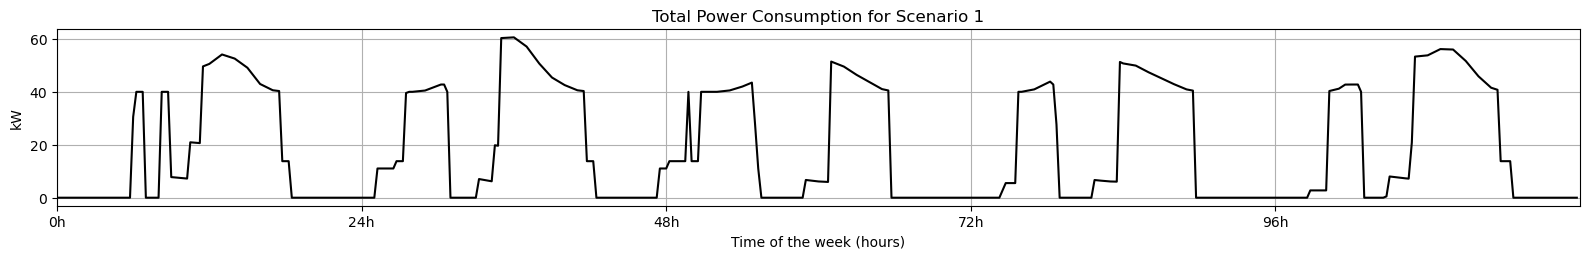

In [130]:
print("Scenario 1:")
Energy_consumption_plot(1, T_in_1, pc_1, ph_1, x_AMM_1, p_ev_1, n_EVS, n_days, slots_per_day, horizon, power_AMM, duration_AMM)

Scenario 2:


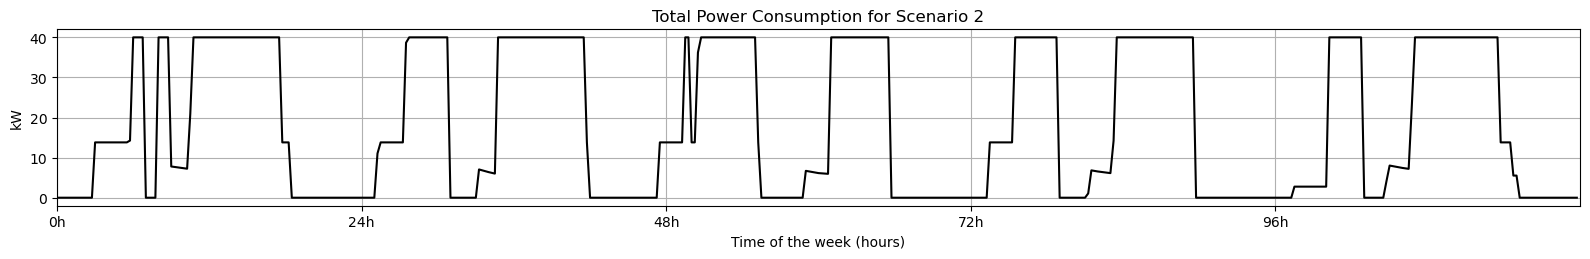

In [131]:
print("Scenario 2:")
Energy_consumption_plot(2, T_in_2, pc_2, ph_2, x_AMM_2, p_ev_2, n_EVS, n_days, slots_per_day, horizon, power_AMM, duration_AMM)

Scenario 3:


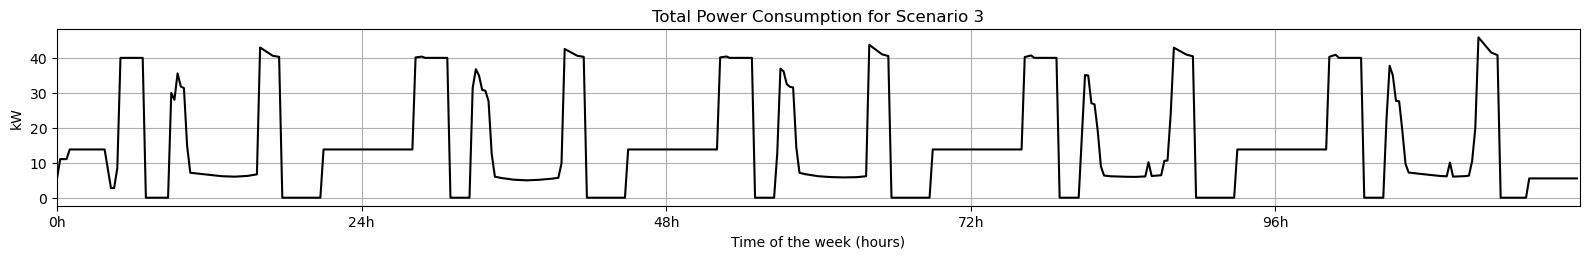

In [132]:
print("Scenario 3:")
Energy_consumption_plot(3, T_in_3, pc_3, ph_3, x_AMM_3, p_ev_3, n_EVS, n_days, slots_per_day, horizon, power_AMM, duration_AMM)

Scenario 4:


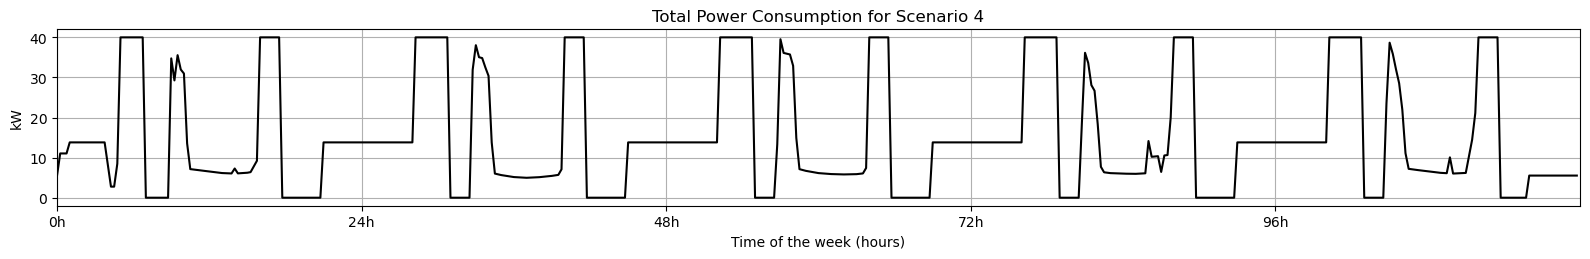

In [133]:
print("Scenario 4:")
Energy_consumption_plot(4, T_in_4, pc_4, ph_4, x_AMM_4, p_ev_4, n_EVS, n_days, slots_per_day, horizon, power_AMM, duration_AMM)

### Detailed Plot

In [134]:

def detailed_plots(scenario, T_in,p_ev,pc, ph, x_AMM, n_days, slots_per_day, n_AMM, horizon, n_EVS):# Extract the values of the decision variables
    EVS = range(n_EVS)
    AMM = range(n_AMM)
    days = range(n_days)

    p_values = np.zeros((n_EVS, n_days, slots_per_day))
    for e in EVS:
        for d in days:
            for t in range(slots_per_day):
                p_values[e, d, t] = p_ev[e, d, t].X

    x_AMM_values = np.zeros((n_AMM, horizon))
    for m in AMM:
        for t in range(horizon):
            x_AMM_values[m, t] = x_AMM[m, t].X

    p_h_values = np.zeros(horizon-1) ### POURQUOI -1 ??????????
    for k in range(horizon-1):
        p_h_values[k] = ph[k].X

    p_c_values = np.zeros(horizon-1)
    for k in range(horizon-1):
        p_c_values[k] = pc[k].X

    T_in_values = np.zeros(horizon)
    for k in range(horizon):
        T_in_values[k] = T_in[k].X
    T_out_values = np.zeros(horizon)
    for k in range(horizon):
        T_out_values[k] = T_out[k]

    # Plot the results

    #EV Plotting
    # Create time axis (0 to 120 hours in 15-min resolution)
    time_axis = np.arange(96 * 5) * 0.25  # 480 time steps

    # Create a 2D array: 15 EVs × 480 time steps
    ev_profiles = np.zeros((n_EVS, 96 * 5))
    for e in EVS:
        profile = []
        for d in days:
            profile.extend(p_values[e, d, :])
        ev_profiles[e] = profile

    # Plot all EV profiles
    plt.figure(figsize=(16, 6))
    for e in EVS:
        plt.plot(time_axis, ev_profiles[e], label=f"EV {e+1}")

    plt.title(f"EV Charging Profiles Over the Week (15 EVs) for scenario {scenario}")
    plt.xlabel("Time (hours)")
    plt.ylabel("Charging Power (kW)")
    plt.xlim(0, 120)  # 0 to 120 hours
    plt.xticks(np.arange(0, 121, 24), [f"{int(i)}h" for i in np.arange(0, 121, 24)])
    plt.grid(True)
    plt.legend(loc='upper right', ncol=3, fontsize='small')
    plt.tight_layout()
    plt.show()

    # Plot the AM machine operation
    plt.figure(figsize=(12, 4))
    for m in AMM:
        plt.plot(x_AMM_values[m, :], label=f"AM Machine {m+1}")
    plt.title(f'AM Machine Operation for scenario {scenario}')
    plt.xlabel('Time Interval (15-min slots)')
    plt.ylabel('Operation (1 = ON, 0 = OFF)')
    hour_ticks = [0, 24 * 4, 48 * 4, 72 * 4, 96 * 4, 120 * 4]  # Convert hours to time steps (4 steps per hour)
    hour_labels = ['0h', '24h', '48h', '72h', '96h', '120h']  # Corresponding labels
    plt.xticks(hour_ticks, hour_labels)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Tracé des températures
    lns1 = ax1.plot(T_in_values,  label='Indoor Temperature [°C]', color='orange')
    lns2 = ax1.plot(T_out_values, label='Outdoor Temperature [°C]', color='green')
    ax1.axhline(y=T_lower, color='gray', linestyle='--', label='Lower Comfort Limit')
    ax1.axhline(y=T_upper, color='gray', linestyle='--', label='Higher Comfort Limit')

    ax1.set_xlabel('Time interval')
    ax1.set_ylabel('Temperature [°C]')
    ax1.grid(True)

    # Création du second axe (puissances) qui partage le même x_AMM
    ax2 = ax1.twinx()
    lns3 = ax2.plot(p_h_values, label='Heating Power [kW]', color='red')
    lns4 = ax2.plot(p_c_values, label='Cooling Power [kW]', color='blue')
    ax2.set_ylabel('Power [kW]')
    fig.legend()

    hour_ticks = [0, 24 * 4, 48 * 4, 72 * 4, 96 * 4, 120 * 4]  # Convert hours to time steps (4 steps per hour)
    hour_labels = ['0h', '24h', '48h', '72h', '96h', '120h']  # Corresponding labels
    plt.xticks(hour_ticks, hour_labels)

    plt.title(f'Temperatures and Heating/Cooling Power for scenario {scenario}')
    plt.tight_layout()
    plt.show()





Scenario 1:


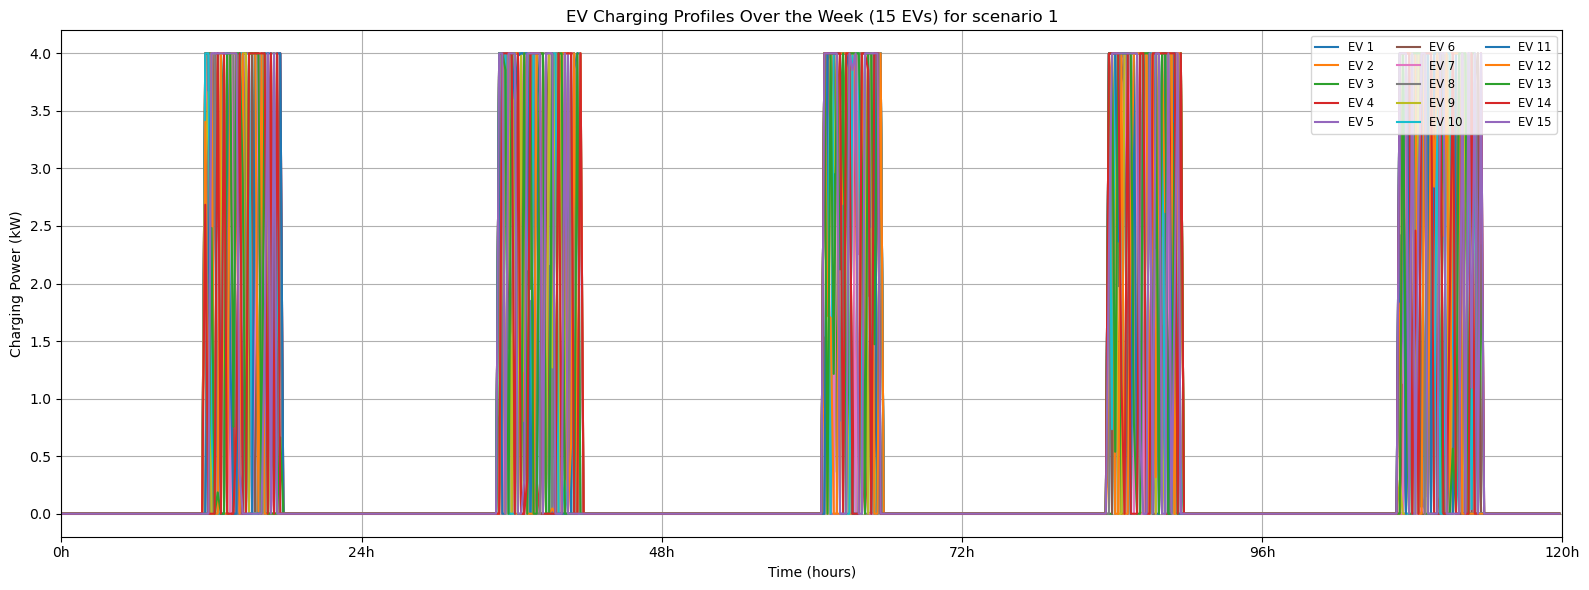

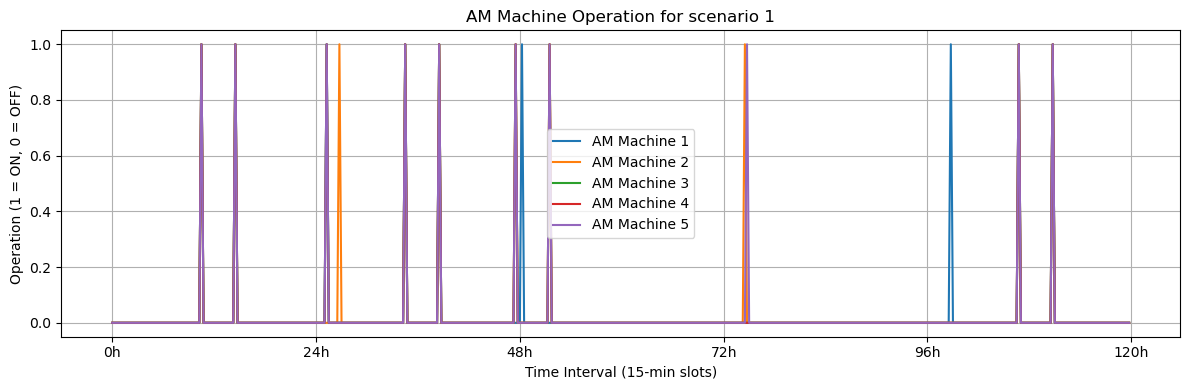

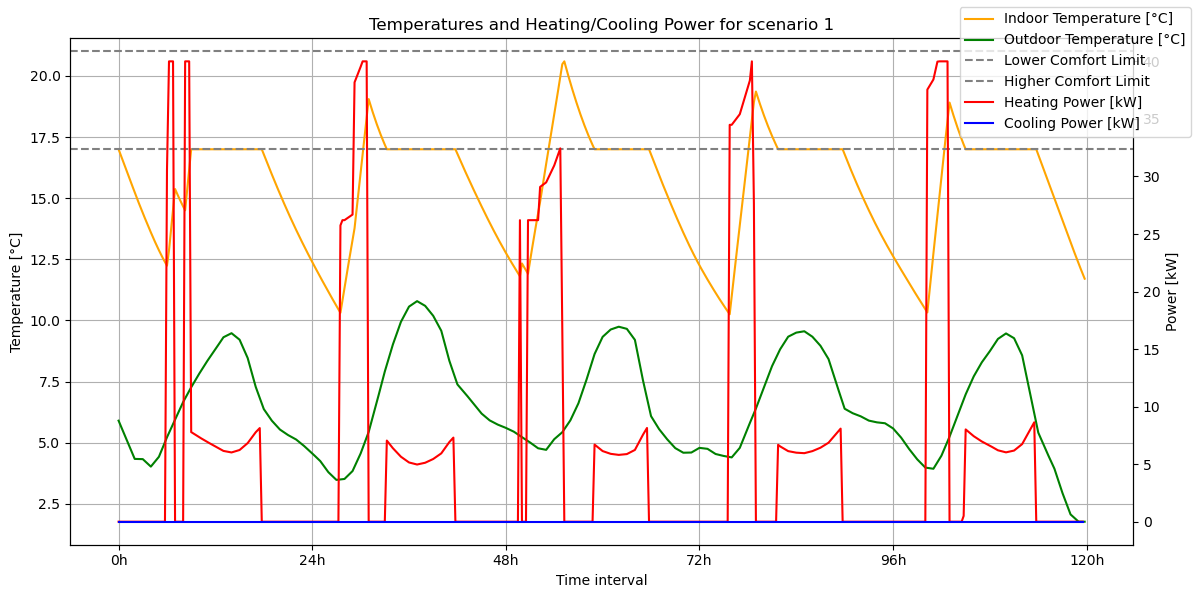

In [135]:
print("Scenario 1:")
detailed_plots(1,T_in_1,p_ev_1,pc_1, ph_1, x_AMM_1, n_days, slots_per_day, n_AMM, horizon, n_EVS)

Scenario 2:


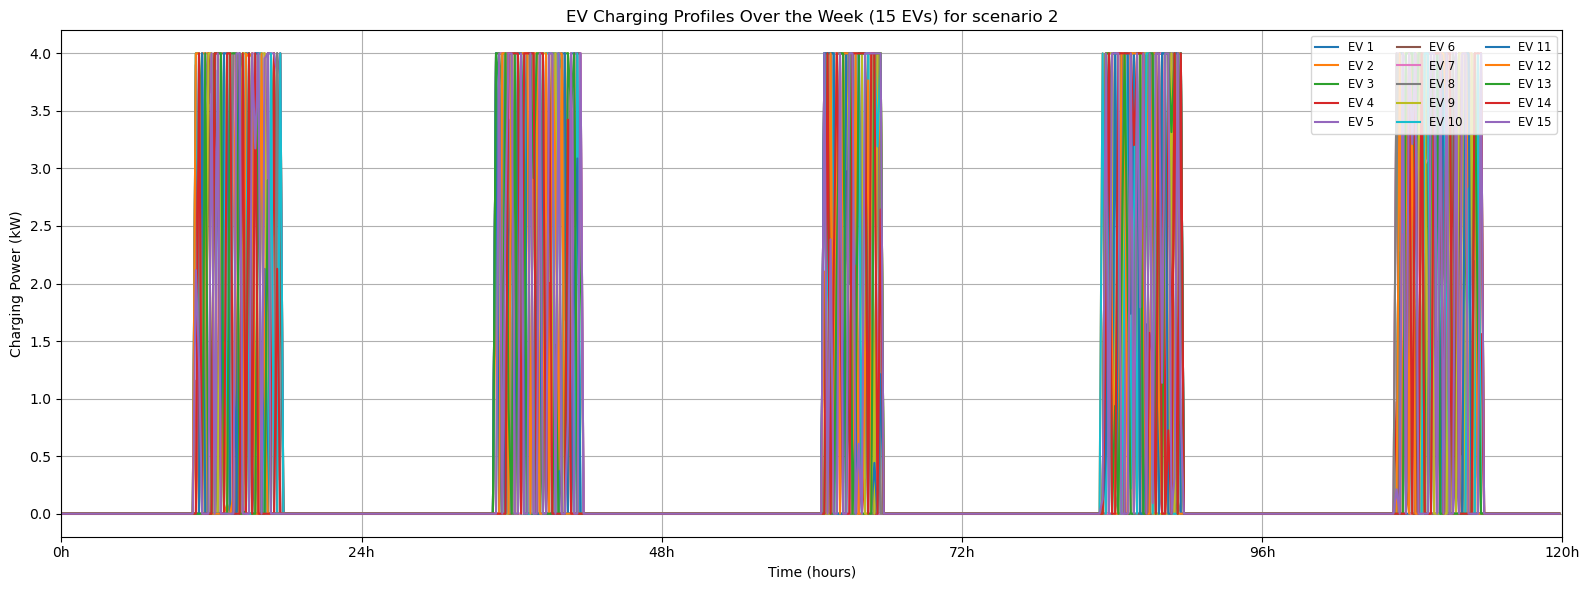

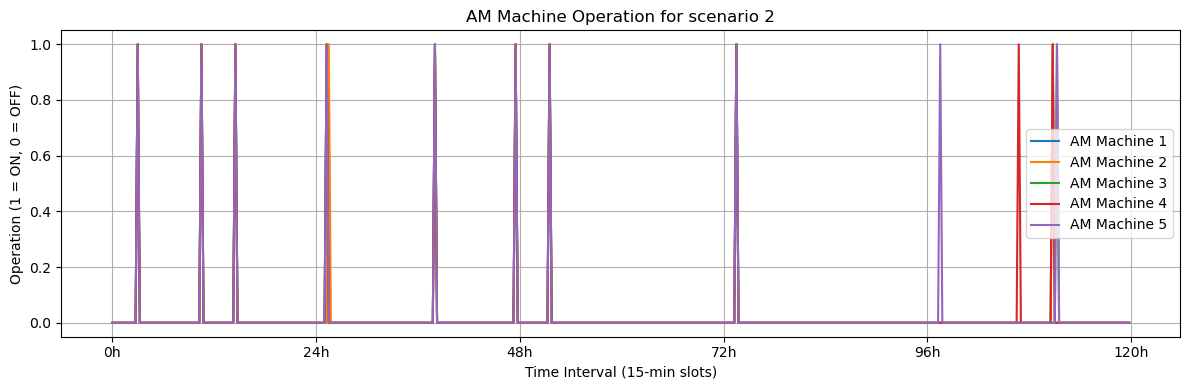

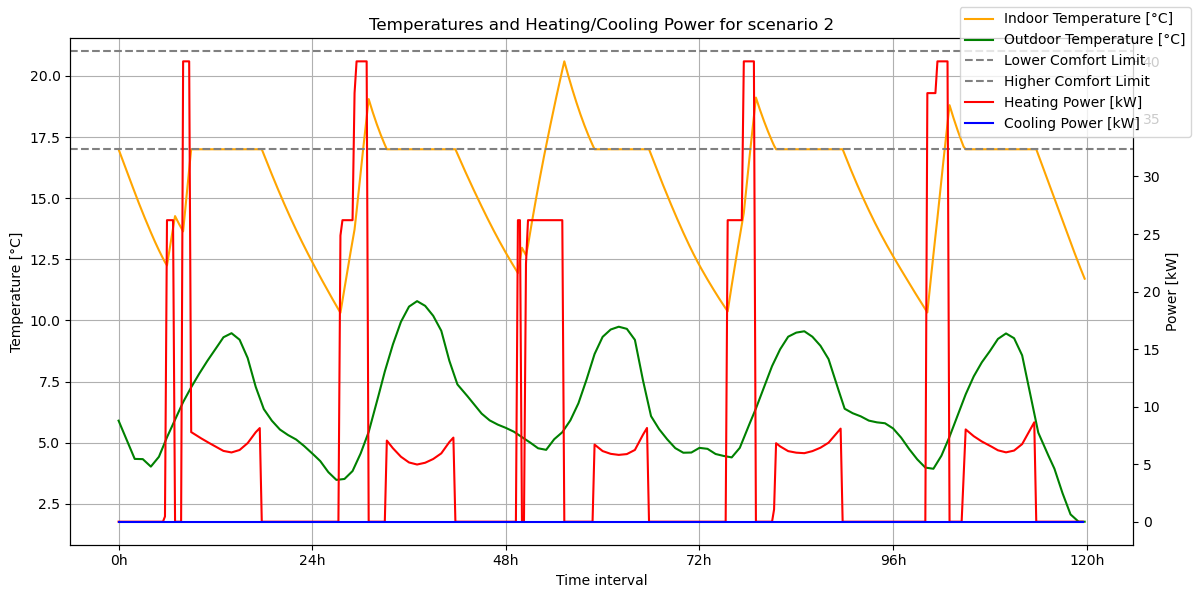

In [136]:
print("Scenario 2:")
detailed_plots(2,T_in_2,p_ev_2,pc_2, ph_2, x_AMM_2, n_days, slots_per_day, n_AMM, horizon, n_EVS)

Scenario 3:


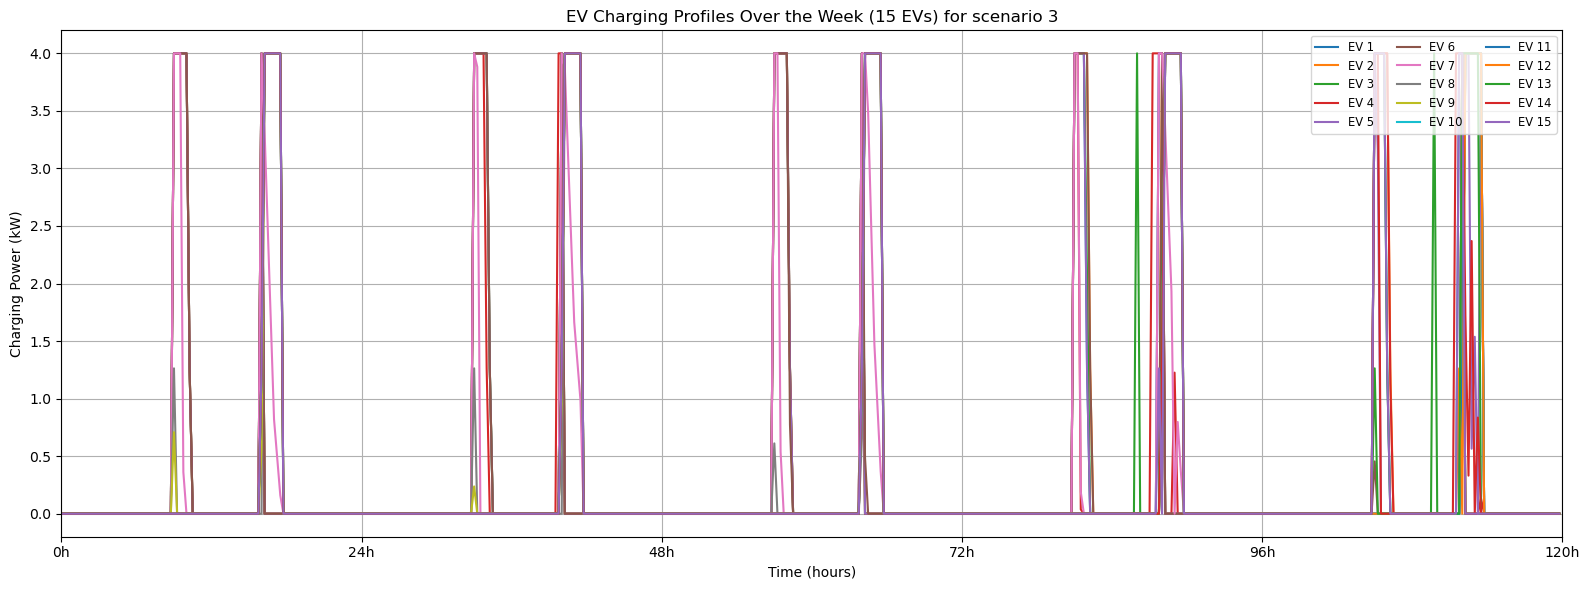

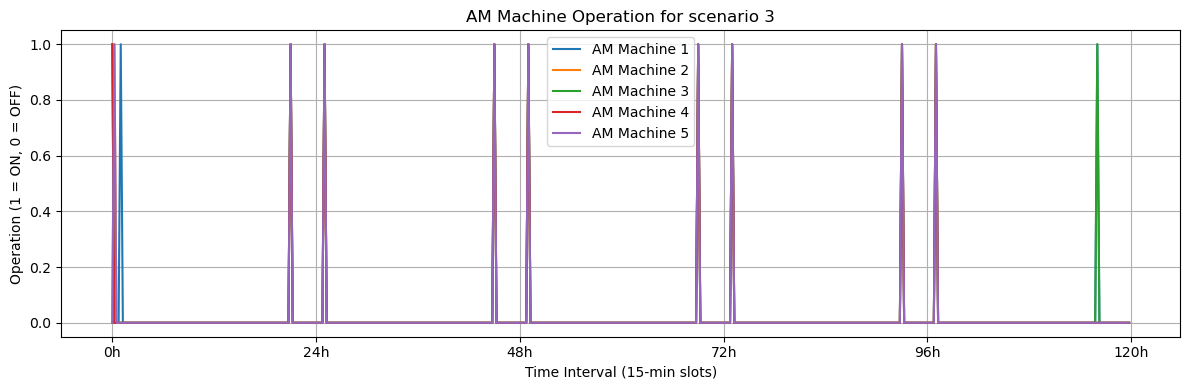

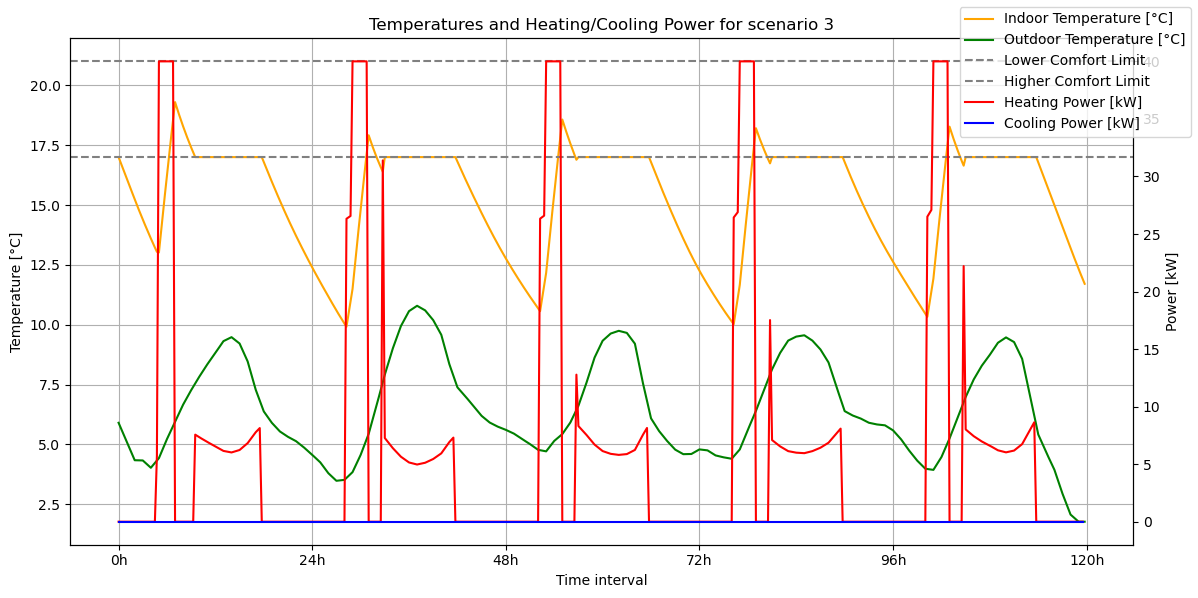

In [137]:
print("Scenario 3:")
detailed_plots(3,T_in_3,p_ev_3,pc_3, ph_3, x_AMM_3, n_days, slots_per_day, n_AMM, horizon, n_EVS)

Scenario 4:


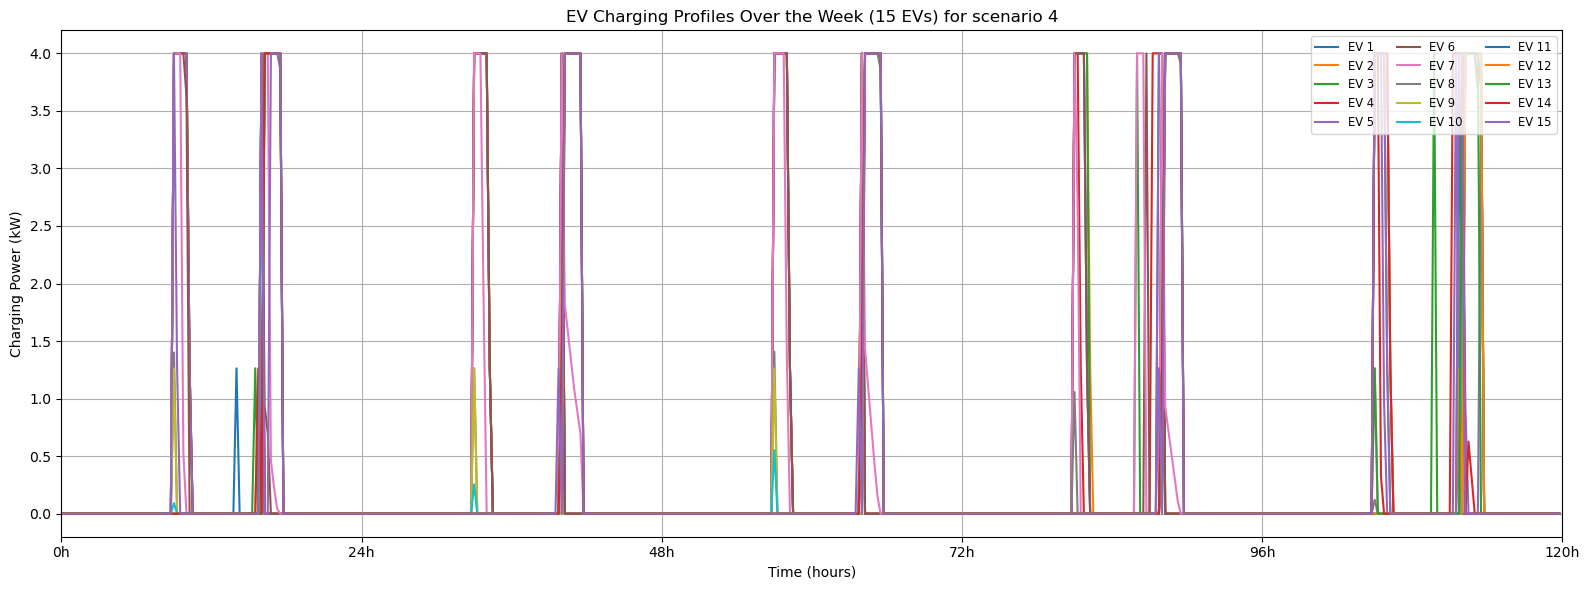

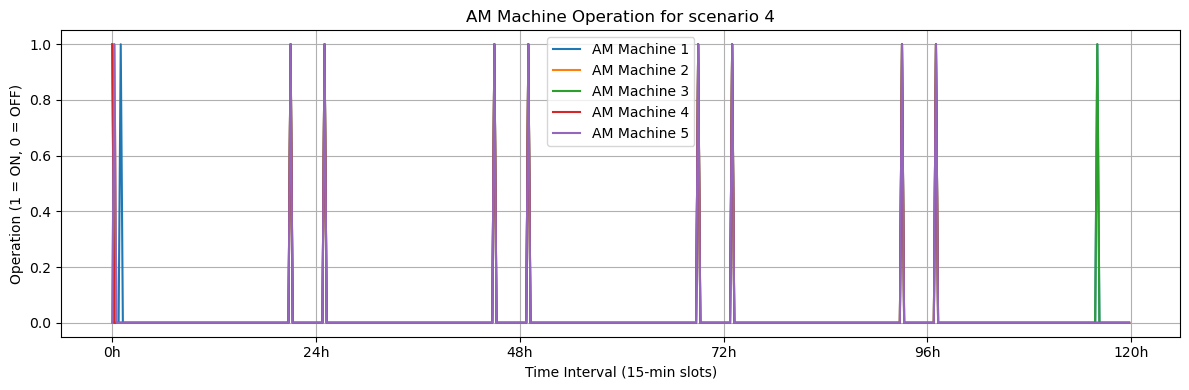

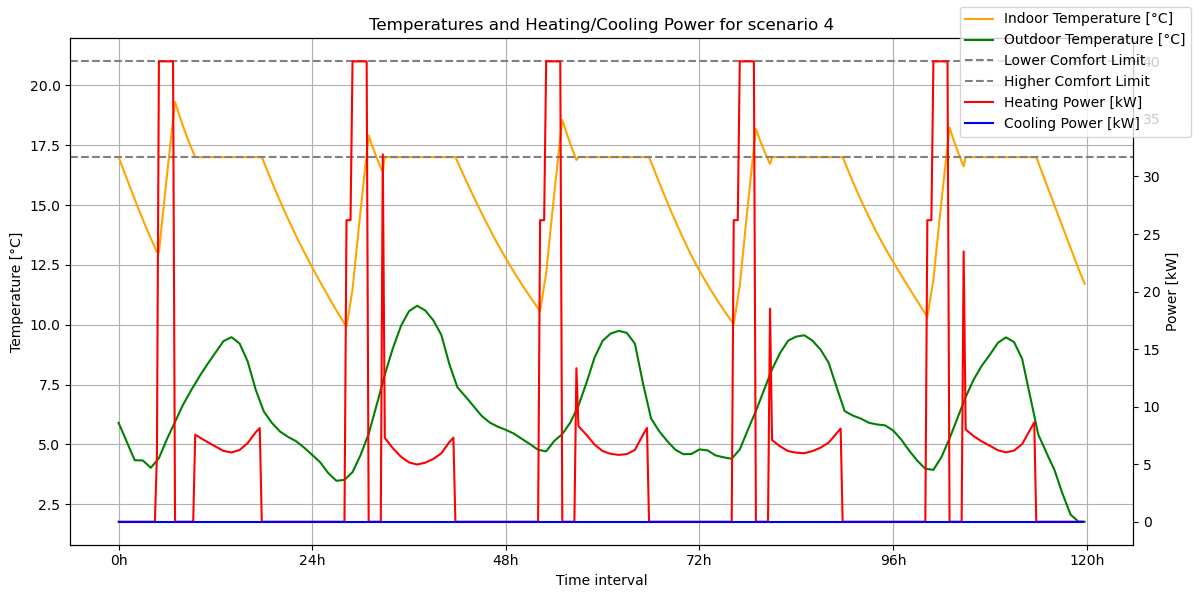

In [138]:
print("Scenario 4:")
detailed_plots(4,T_in_4,p_ev_4,pc_4, ph_4, x_AMM_4, n_days, slots_per_day, n_AMM, horizon, n_EVS)

### Charging and Discharging profile of one EV

In [139]:

def plot_ev_charging_profile(ev_id, soc, p_ev_charge, p_ev_discharge,
                              n_days, slots_per_day, dt, prices,
                              work_start_hour=9, work_end_hour=18):
    total_slots = n_days * slots_per_day
    time_axis = np.arange(total_slots) * dt  # time in hours

    soc_vals = []
    charge_vals = []
    discharge_vals = []

    for d in range(n_days):
        for t in range(slots_per_day):
            soc_vals.append(soc[ev_id, d, t].X)
            charge_vals.append(p_ev_charge[ev_id, d, t].X)
            discharge_vals.append(-p_ev_discharge[ev_id, d, t].X)  # negative for plotting

    fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 8), sharex=True,
                                   gridspec_kw={"height_ratios": [3, 1]})

    # --- Main plot: SoC and Power ---
    for d in range(n_days):
        day_start = d * 24 + work_start_hour
        day_end = d * 24 + work_end_hour
        ax1.axvspan(day_start, day_end, color='yellow', alpha=0.15, label="Work Hours" if d == 0 else "")

    # SoC (left y-axis)
    ax1.plot(time_axis, soc_vals, label="State of Charge (kWh)", color="blue", linewidth=2)
    ax1.set_ylabel("SoC (kWh)", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.grid(True)

    # Charging/discharging (right y-axis)
    ax2 = ax1.twinx()
    ax2.bar(time_axis, charge_vals, width=dt, label="Charging Power (kW)", color="green", alpha=0.5)
    ax2.bar(time_axis, discharge_vals, width=dt, label="Discharging Power (kW)", color="red", alpha=0.5)
    ax2.set_ylabel("Power (kW)", color="black")
    ax2.tick_params(axis='y', labelcolor="black")

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    ax1.set_title(f"EV {ev_id} Weekly Charging Profile with SoC and Power")

    # --- Subplot: Price ---
    ax3.plot(time_axis, prices, color="orange", label="Dynamic Price (CHF/kWh)")
    ax3.set_ylabel("Price (CHF/kWh)")
    ax3.set_xlabel("Time (hours)")
    ax3.grid(True)
    ax3.legend(loc="upper left")
    ax3.set_title("Dynamic Electricity Price")

    plt.tight_layout()
    plt.show()


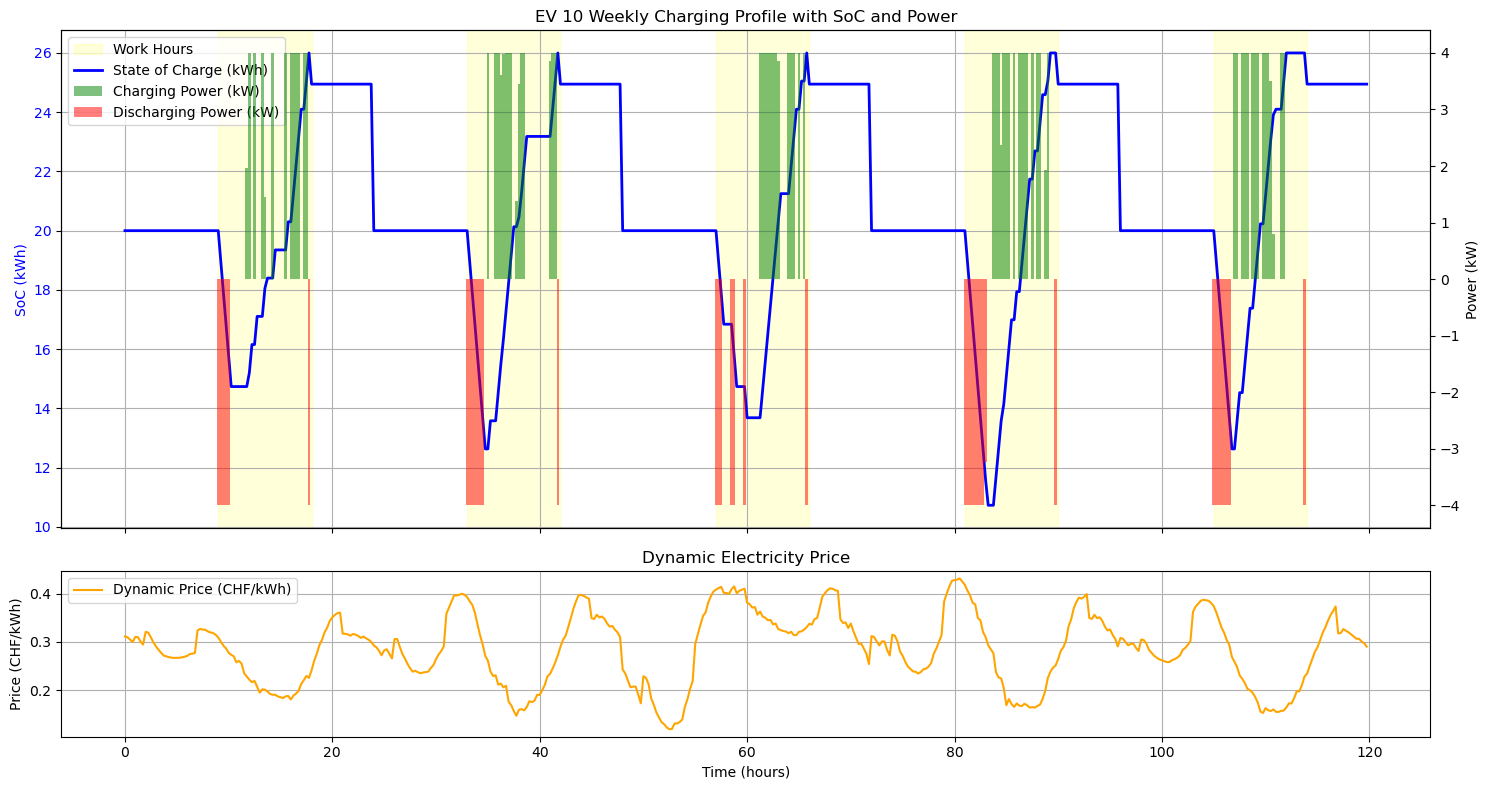

In [140]:
plot_ev_charging_profile(10,soc_1,p_ev_1,p_ev_discharge_1,n_days,slots_per_day,dt, dynamic_prices)
#results change depending on the EV chosen.

In [141]:
# Piece of code to print the results of the four scenarios and copy them in PriceVSThreshold.py

results = np.zeros(4)

results[0] = print_consumption(1, model1, p_ev_1, p_ev_discharge_1, dynamic_prices, x_AMM_1, ph_1, pc_1, n_days, power_AMM, cost_EV_1, cost_AMM_1, cost_HC_1, cost_critical_1, cost_PV_1)
results[1] = print_consumption(2, model2, p_ev_2,p_ev_discharge_2, dynamic_prices, x_AMM_2,ph_2,pc_2, n_days, power_AMM,cost_EV_2,cost_AMM_2,cost_HC_2,cost_critical_2,cost_PV_2)
results[2] = print_consumption(3, model3, p_ev_3,p_ev_discharge_3, Base_Peak_prices, x_AMM_3,ph_3,pc_3,n_days, power_AMM,cost_EV_3,cost_AMM_3,cost_HC_3,cost_critical_3,cost_PV_3)
results[3] = print_consumption(4, model4, p_ev_4, p_ev_discharge_4, Base_Peak_prices, x_AMM_4,ph_4,pc_4,n_days, power_AMM,cost_EV_4,cost_AMM_4,cost_HC_4,cost_critical_4,cost_PV_4)

print(results)

 Weekly Energy Consumption Breakdown (CHF):
  - EV Charging:     1009.79 kWh
  - AM Machines:     518.88 kWh
  - Heating:         804.24 kWh
  - Cooling:         0.00 kWh
  - Critical Loads:  794.68 kWh
  -----------------------------
 Total energy consumed during the week: 3127.59 kWh 

 Weekly Cost Breakdown (CHF):
  - EV Charging Cost:       CHF 222.29
  - EV Discharging Revenue: CHF -191.61
  - EV Net Cost:            CHF 30.68
  - AM Machines:            CHF 110.58
  - Heating/Cooling:        CHF 194.61
  - Critical Loads:         CHF 225.53
  - PV Energy:              CHF -578.84
  -----------------------------
  Total Costs from Objective function: CHF -17.43

 Weekly Energy Consumption Breakdown (CHF):
  - EV Charging:     875.07 kWh
  - AM Machines:     518.88 kWh
  - Heating:         804.14 kWh
  - Cooling:         0.00 kWh
  - Critical Loads:  794.68 kWh
  -----------------------------
 Total energy consumed during the week: 2992.77 kWh 

 Weekly Cost Breakdown (CHF):
  - EV

## Uncontrolled Baseline function

In [152]:
def compute_uncontrolled_baseline(prices, critical_demand, slots_per_day=96, n_days=5,
                                                  dt=0.25, n_EVS=15, ev_energy_kwh=6.0,
                                                  amm_power_kw=2.76, amm_duration_slots=16,
                                                  heater_power_kw=40.0, work_start=36, work_end=72):
    total_slots = slots_per_day * n_days
    total_demand = np.zeros(total_slots)

    """
    Computes the uncontrolled baseline cost and demand breakdown for a week, considering:
    - Critical appliances with fixed demand, just as in the optimization.
    -Each EV charges 6 kWh/day, linearly spread across working hours (9:00–18:00), No vehicle-to-grid (V2G) discharging allowed
    - Heating system with constant 40 kW during office hours
    - AMM jobs with 47 jobs, each lasting 16 slots, evenly distributed across all 5 days, using day and night hours (24h)
    -no PV generation considered in this uncontrolled baseline.
    -dynamic prices are used to compute the cost of each component.
    """

    # Initialize cost components
    cost_EV = 0.0
    cost_AMM = 0.0
    cost_HC = 0.0
    cost_critical = 0.0

    prices_arr = np.array(prices)
    critical_arr = np.array(critical_demand)

    # 1) Critical appliances
    for t in range(total_slots):
        total_demand[t] += critical_arr[t]
        cost_critical += critical_arr[t] * prices_arr[t]  # already in kWh × CHF/kWh = CHF

    # 2) EV Charging: each EV charges 6 kWh linearly over work hours
    ev_charge_power_per_slot = ev_energy_kwh / ((work_end - work_start) * dt)
    ev_charge_total = n_EVS * ev_charge_power_per_slot

    for d in range(n_days):
        for t in range(work_start, work_end):
            idx = d * slots_per_day + t
            total_demand[idx] += ev_charge_total
            cost_EV += ev_charge_total * prices_arr[idx] * dt

    # 3) Heating: constant 40 kW during office hours
    for d in range(n_days):
        for t in range(work_start, work_end):
            idx = d * slots_per_day + t
            total_demand[idx] += heater_power_kw
            cost_HC += heater_power_kw * prices_arr[idx] * dt

    # 4) AMM: 47 jobs, 16-slot duration each, evenly scheduled across full 5 days (day and night)
    total_amm_jobs = 47
    job_duration = amm_duration_slots

    # Build all feasible starting points where a full job can fit (within 480 slots)
    candidate_starts = list(range(0, total_slots - job_duration + 1))

    # Pick 47 evenly spaced job start indices
    selected_starts = np.linspace(0, len(candidate_starts) - 1, total_amm_jobs, dtype=int)
    selected_slots = [candidate_starts[i] for i in selected_starts]

    for start in selected_slots:
        for s in range(job_duration):
            idx = start + s
            if idx < total_slots:
                total_demand[idx] += amm_power_kw
                cost_AMM += amm_power_kw * prices_arr[idx] * dt

    # 6) Total cost
    total_cost = cost_critical + cost_EV + cost_AMM + cost_HC

    # Breakdown summary
    print("Uncontrolled Cost Breakdown:")
    print(f"   Critical Load Cost       : CHF {cost_critical:.2f}")
    print(f"   EV Charging Cost         : CHF {cost_EV:.2f}")
    print(f"   AMM Jobs Cost            : CHF {cost_AMM:.2f}")
    print(f"   Heating System Cost      : CHF {cost_HC:.2f}")
    print(f"   Total Baseline Cost      : CHF {total_cost:.2f}")

    return total_cost, total_demand


In [153]:
total_cost_baseline, demand_baseline = compute_uncontrolled_baseline(prices=dynamic_prices,critical_demand=critical_demand)

Uncontrolled Cost Breakdown:
   Critical Load Cost       : CHF 225.53
   EV Charging Cost         : CHF 115.10
   AMM Jobs Cost            : CHF 147.62
   Heating System Cost      : CHF 460.40
   Total Baseline Cost      : CHF 948.65
